### TASK C

### a. Streaming Visualisation

In [ ]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'

import Geohash #pip install Geohash
import ast
import sys
import time
import json
import matplotlib.pyplot as plt

from pymongo import MongoClient
from kafka import KafkaConsumer
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext

client = MongoClient()
db = client.fit5148_db
clm = db.climate_his
hot = db.hotspots_his
model = db.clim_hot_model

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show(); # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8')).split(',',2)
            data1=json.loads(data[2].replace('\'','\"',20))
            x.append(data[1]) 
            y.append(float(data1['air_temperature_celcius']))
            # print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                ax.set_ylim(0,110) 
                ax.set_yticks([0,20,40,60,80,100])
                annotate_max(x, y, ax)
                annotate_min(x, y, ax)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))

topic = 'TaskC'   

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

### b. Static data visualisation

### i.

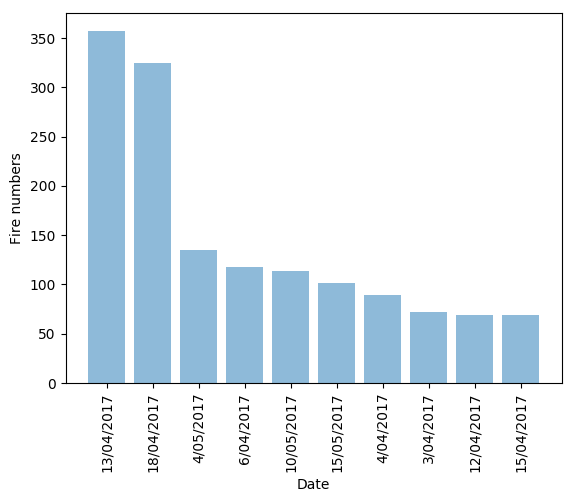

In [2]:
from pprint import pprint
from pymongo import MongoClient
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


client = MongoClient()
db = client.fit5148_db
hot = db.hotspots_his


xaxis = []
yaxis = []

result = db.hotspots_his.aggregate([{"$group":{"_id" :"$date" , "count": {"$sum":1}}},{"$sort":{'count':-1}},{ "$limit" : 10 }])

for document in result:
    xaxis.append(document['_id'])
    yaxis.append(document['count'])

plt.bar(xaxis, yaxis, align='center', alpha=0.5)
plt.xticks(rotation='vertical')
plt.ylabel('Fire numbers')
plt.xlabel('Date')

plt.show()


client.close()

### ii.

In [ ]:
import gmplot
import webbrowser
from pprint import pprint
from pymongo import MongoClient
import Geohash #pip install Geohash

# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city

client = MongoClient()
db = client.fit5148_db
model = db.clim_hot_model

data = model.aggregate([{"$unwind":"$hot_spot_records"},{'$project':{'latitude':"$hot_spot_records.latitude",'longitude':"$hot_spot_records.longitude","surface_temperature":"$hot_spot_records.surface_temperature_celcius","air_temperature":"$air_temperature_celcius","confidence":"$hot_spot_records.confidence","relative_humidity":"$relative_humidity"}}])

newdata = []
for i in data:
    i['geo'] = Geohash.encode(i['latitude'], i['longitude'], precision=5)
    newdata.append(i)

for i in newdata:
    gmap.marker(float(i['latitude']), float(i['longitude']), 'red', title = str('surface_temperature:'+str(i['surface_temperature'])+', air_temperature:'+str(i['air_temperature'])+', relative_humidity:'+str(i['relative_humidity'])+', confidence:'+str(i['confidence'])))
    
# Open web browser and draw the map
gmap.draw("firemap.html")
webbrowser.open_new("firemap.html")
    